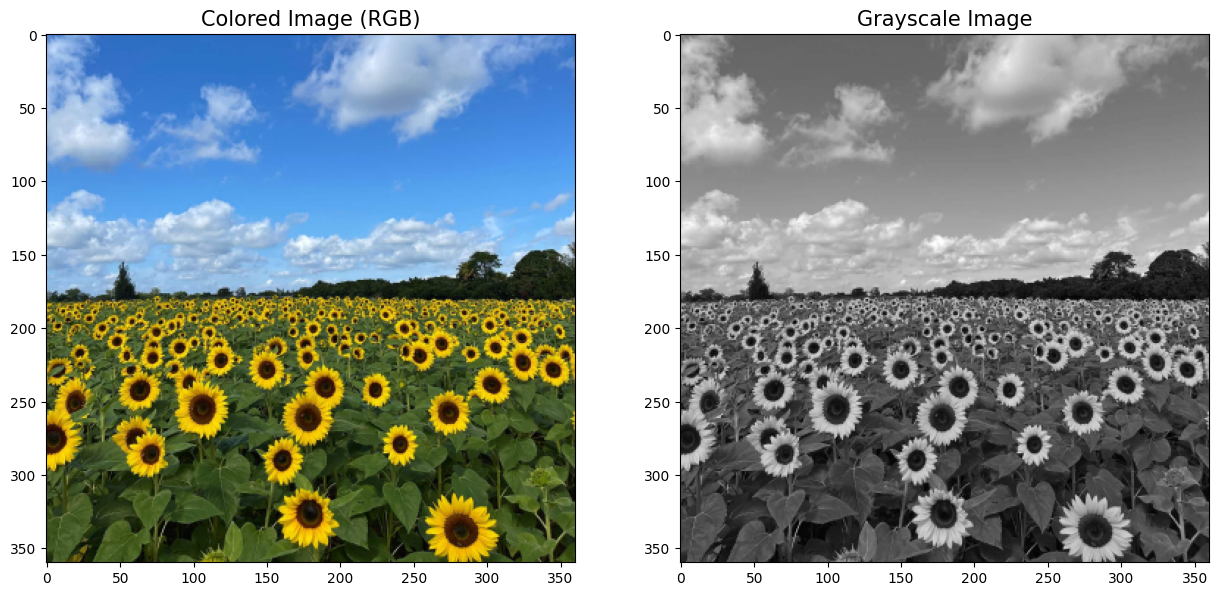

In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

# Convert from BGR to RGB for correct color display in matplotlib
im_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(im_rgb)  # Display RGB image
ax[1].imshow(gray, cmap='gray')  # Display grayscale image
ax[0].set_title('Colored Image (RGB)', fontsize=15)
ax[1].set_title('Grayscale Image', fontsize=15)
plt.show()



Largest Circle Parameters:
Radius: 72.40773439350254
Center Coordinates (x, y): (0, 108)

Range of σ values used:
Minimum σ: 0.4
Maximum σ: 51.200000000000045



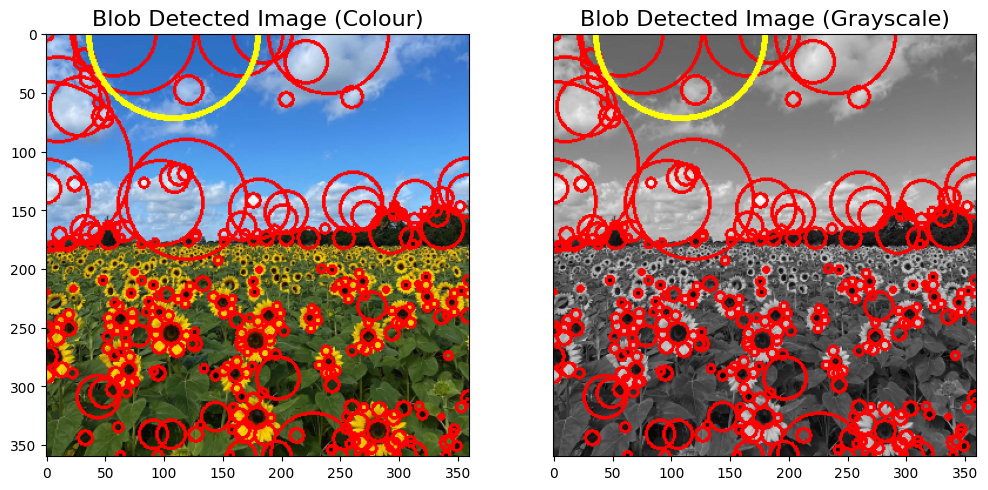

In [10]:
import cv2 as cv
# Function Definitions

def log_kernel(sigma, size):

        if size % 2 == 0:  # Ensure kernel size is odd
                size = size + 1

        sigma2 = sigma ** 2  # Compute sigma squared
        idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)  # Create index range for the kernel
        x_idx, y_idx = np.meshgrid(idx_range, idx_range)  # Generate 2D grid of indices
        tmp_cal = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma2)  # Compute exponential part of the Gaussian
        kernel = np.exp(tmp_cal)  # Generate Gaussian kernel
        kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0  # Remove values too close to zero
        k_sum = np.sum(kernel)  # Sum up the kernel elements

        if k_sum != 0:
                kernel /= np.sum(kernel)  # Normalize the kernel

        tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma2) / (sigma2 ** 2)  # Combine Gaussian and Laplacian components
        kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2)  # Final Laplacian of Gaussian (LoG) filter
        return kernel



def show_kernel(kernel):
        plt.imshow(kernel, cmap='viridis')
        plt.colorbar()
        plt.title('Kernel')
        plt.show()

gray = np.float32(gray) # Change data type to float32
cv.normalize(gray, gray, 1, 0, cv.NORM_MINMAX) # Normalize pixel intensity values


sigma0 = 0.4 # Initial sigma, determined by trial and error for optimal results
k = np.sqrt(2) # Scale factor for sigma
num_scales = 15 # Define the number of scales for LoG filtering
sigmas = sigma0 * np.power(k, np.arange(num_scales)) # Array of sigma values for each scale


# Apply LoG filter across multiple scales
img_stack = None

for i in range(num_scales):

        size = int(2 * np.ceil(4 * sigmas[i]) + 1) # Determine kernel size based on sigma

        kernel = log_kernel(sigmas[i], size) * np.power(sigmas[i], 2) # Create LoG kernel for the current scale
        #show_kernel(kernel) # Uncomment to visualize the kernel

        filtered = cv.filter2D(gray, cv.CV_32F, kernel) # Apply LoG filter to the grayscale image
        filtered = pow(filtered, 2) # Square the result to enhance features
        
        # Stack the filtered images from each scale
        if i == 0:  
                img_stack = filtered 
        else:
                img_stack = np.dstack((img_stack, filtered)) 


# Extract the maximum response for each scale
scale_space = None 

for i in range(num_scales):
        filtered = cv.dilate(img_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT) # Perform dilation to emphasize local maxima
        
        # Stack the dilated images
        if i == 0:
                scale_space = filtered
        else:
                scale_space = np.dstack((scale_space, filtered))


# Find the maximum value across all scales
max_stack = np.amax(scale_space, axis=2)  # Get the maximum response from all scales
max_stack = np.repeat(max_stack[:, :, np.newaxis], num_scales, axis=2)  # Duplicate the max response across all scales
max_stack = np.multiply((max_stack == scale_space), scale_space)  # Retain only the maximum responses from each scale


# Initialize vectors for storing blob information
radius_vec = None
x_vec = None
y_vec = None


for i in range(num_scales):
        
        radius = np.sqrt(2) * sigmas[i] # Calculate the radius of detected blobs
        threshold = 0.01 # Set a threshold to eliminate weak responses
        valid = (max_stack[:, :, i] == img_stack[:, :, i]) * img_stack[:, :, i] # Retain valid maximum responses only
        valid[valid <= threshold] = 0 # Zero out responses below the threshold
        (x, y) = np.nonzero(valid) # Find coordinates of detected blobs
        
        if i == 1:
                x_vec = x # Store x coordinates of blobs
                y_vec = y # Store y coordinates of blobs             
                radius_vec = np.repeat(radius, np.size(x)) # Store blob radius
        else:
                x_vec = np.concatenate((x_vec, x), axis=None) # Append x coordinates
                y_vec = np.concatenate((y_vec, y), axis=None) # Append y coordinates
                tmp_vec = np.repeat(radius, np.size(x)) # Store radius values for all blobs
                radius_vec = np.concatenate((radius_vec, tmp_vec), axis=None) # Append radius vector


# Identify the largest circle
max_radius = np.max(radius_vec)
max_circle_idx = np.argmax(radius_vec)
max_x = x_vec[max_circle_idx]
max_y = y_vec[max_circle_idx]


# Display parameters of the largest circle
print()
print(f"Largest Circle Parameters:")
print(f"Radius: {max_radius}")
print(f"Center Coordinates (x, y): ({max_x}, {max_y})")

# Show the range of sigma values used
min_sigma = np.min(sigmas)
max_sigma = np.max(sigmas)
print(f"\nRange of σ values used:")
print(f"Minimum σ: {min_sigma}")
print(f"Maximum σ: {max_sigma}")
print()


# Convert original image to grayscale and back to BGR for visualization
out = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
out = cv.cvtColor(out, cv.COLOR_GRAY2BGR) 


out_colour    = img.copy()  # Create a copy of the original for colouring detected blobs
out_grayscale = out.copy()  # Duplicate for grayscale version of blobs


for i in range(np.size(x_vec)):
        if i == max_circle_idx: 
                # Highlight the largest circle in yellow
                cv.circle(out_colour, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0,255,255), 3)   
                cv.circle(out_grayscale, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0,255,255), 3)  
        else:
                # Mark other circles in red
                cv.circle(out_colour, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0, 0, 255), 2)  
                cv.circle(out_grayscale, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0, 0, 255), 2)  

# Save the output images
cv.imwrite("../Outputs/" + img_name + "blob_detected_COLOUR.jpeg", out_colour)
cv.imwrite("../Outputs/" + img_name + "blob_detected_GRAY.jpeg", out_grayscale)


# Display the images side by side using Matplotlib
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(out_colour, cv.COLOR_BGR2RGB))
plt.title("Blob Detected Image (Colour)",fontsize=16)
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(out_grayscale,cv.COLOR_BGR2RGB), cmap='gray') 
plt.yticks([])
plt.title("Blob Detected Image (Grayscale)",fontsize=16)
plt.show()


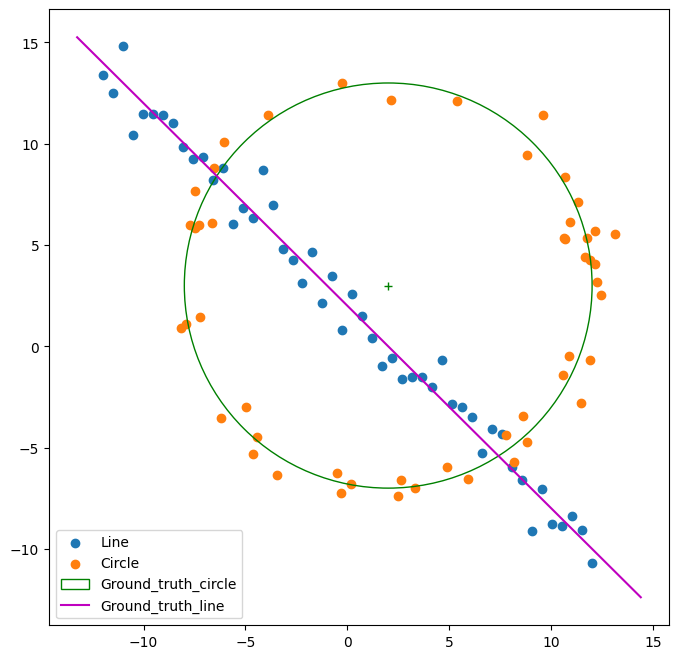

In [17]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt

# np.random.seed(0)
N= 100
half_n =N//2

r = 10
x0_gt , y0_gt = 2, 3 # Center
s = r/16
t = np.random.uniform(0, 2*np.pi , half_n)
n = s*np.random.randn(half_n)
x, y = x0_gt + (r + n)*np.cos(t), y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n ,1) , y.reshape(half_n ,1)))
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n ,1) , y.reshape(half_n ,1)))
X = np.vstack((X_circ , X_line )) # All points
fig , ax = plt.subplots(1,1, figsize =(8 ,8))
ax. scatter (X_line [: ,0] , X_line [: ,1] , label= 'Line')
ax. scatter ( X_circ [: ,0] , X_circ [: ,1] , label= 'Circle' )
circle_gt = plt . Circle ((x0_gt ,y0_gt) , r , color= 'g' , fill=False , label='Ground_truth_circle')
ax. add_patch( circle_gt )
ax. plot (( x0_gt) , (y0_gt) , '+' , color= 'g' )
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt . plot (x_ , y_, color= 'm' , label='Ground_truth_line')
plt . legend ()

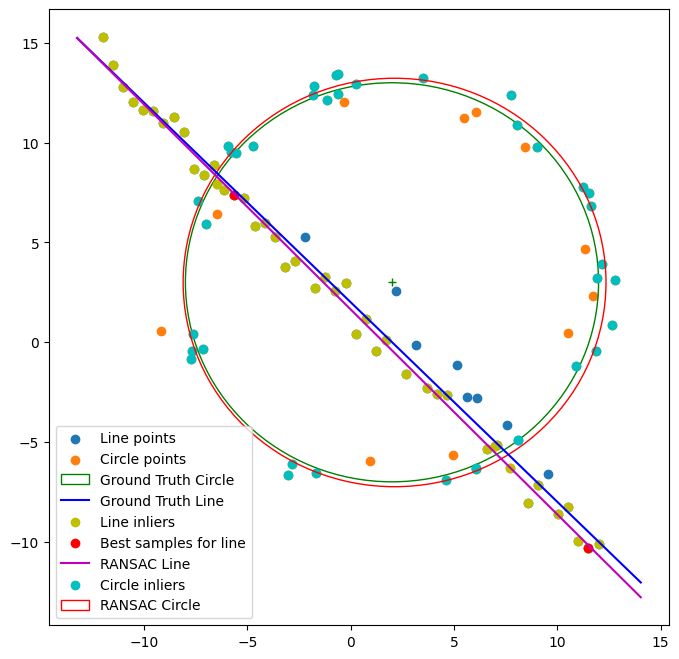

In [11]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Generate noisy point set
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth circle center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x_circle = x0_gt + (r + n) * np.cos(t)
y_circle = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x_circle.reshape(half_n, 1), y_circle.reshape(half_n, 1)))

# Line generation
s = 1.0
m, b = -1, 2  # Line parameters: slope and intercept
x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s * np.random.randn(half_n)
X_line = np.hstack((x_line.reshape(half_n, 1), y_line.reshape(half_n, 1)))

# Combine points into a single dataset
X = np.vstack((X_circ, X_line))

# Plot initial points (circle and line)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line points')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle points')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')  # Ground truth center
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# Plot ground truth line
x_vals = np.array([x_min, x_max])
y_vals = m * x_vals + b
plt.plot(x_vals, y_vals, color='b', label='Ground Truth Line')
plt.legend()

# RANSAC for line
def line_total_error(x, line_indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a * X[line_indices, 0] + b * X[line_indices, 1] - d))

def cons(x):
    return x[0]**2 + x[1]**2 - 1

constraint = {'type': 'eq', 'fun': cons}

def line_consensus_set(X, x, line_threshold):
    a, b, d = x[0], x[1], x[2]
    error = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return error < line_threshold

# RANSAC for Line
line_max_iterations = 100
line_threshold = 1.0
line_data_points = 0.4 * N
line_best_error = np.inf
line_sample = 2

best_line_indices = []
best_line_model = []
best_line_inliers = []
line_iteration = 0

while line_iteration < line_max_iterations:
    line_indices = np.random.randint(0, N, line_sample)  # Randomly select points
    x0 = np.array([1, 1, 0])  # Initial guess for line parameters
    res = minimize(line_total_error, x0=x0, args=(line_indices,), tol=1e-6, constraints=constraint)
    line_inliers = line_consensus_set(X, res.x, line_threshold)  # Find inliers

    if np.sum(line_inliers) > line_data_points:
        res = minimize(line_total_error, x0=res.x, args=(line_inliers,), tol=1e-6, constraints=constraint)
        if res.fun < line_best_error:
            line_best_error = res.fun
            best_line_indices = line_indices
            best_line_model = res.x
            best_line_inliers = line_inliers

    line_iteration += 1

# Plot RANSAC line results
ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], color='y', label='Line inliers')
ax.scatter(X[best_line_indices, 0], X[best_line_indices, 1], color='r', label='Best samples for line')
y_vals_ransac = (-best_line_model[0] * x_vals + best_line_model[2]) / best_line_model[1]
plt.plot(x_vals, y_vals_ransac, color='m', label='RANSAC Line')

# RANSAC for Circle
line_outliers = np.where(best_line_inliers == False)[0]
remnants = np.array([X[line_outliers[i]] for i in range(len(line_outliers))])

def circle_tls(x, indices):
    x0, y0, r = x
    x1, y1 = remnants[indices].T
    return np.sum((np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2)

def circle_consensus_set(remnants, x, circle_threshold):
    distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
    return distances < circle_threshold

# RANSAC for Circle
circle_threshold = 1.0
max_circle_iterations = 100
circle_best_error = np.inf
circle_best_model = []
circle_best_inliers = []
circle_iteration = 0
circle_sample = 3

while circle_iteration < max_circle_iterations:
    circle_indices = np.random.randint(0, len(remnants), circle_sample)
    x0 = np.array([0, 0, 0])  # Initial guess for circle center and radius
    res = minimize(circle_tls, x0=x0, args=circle_indices, tol=1e-6)
    circle_inliers = circle_consensus_set(remnants, res.x, circle_threshold)

    if np.sum(circle_inliers) > 35:  # Require a minimum number of points in the circle consensus
        res = minimize(circle_tls, x0=res.x, args=(circle_inliers,), tol=1e-6)
        if res.fun < circle_best_error:
            circle_best_error = res.fun
            circle_best_model = res.x
            circle_best_inliers = circle_inliers

    circle_iteration += 1

# Plot RANSAC circle results
ax.scatter(remnants[circle_best_inliers, 0], remnants[circle_best_inliers, 1], color='c', label='Circle inliers')
best_circle = plt.Circle((circle_best_model[0], circle_best_model[1]), circle_best_model[2], color='r', fill=False, label='RANSAC Circle')
ax.add_patch(best_circle)

ax.legend()
plt.show()


Image shape: (768, 1024, 3)
Flag shape: (960, 1920, 3)
Please select four points in clockwise order by left-clicking.
You can right-click to remove the last selected point.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ordered Points (Clockwise): [(467, 306), (854, 267), (462, 549), (874, 543)]
Homography matrix:
 [[ 1.47850835e-01 -3.15893158e-02  4.67000000e+02]
 [-3.71052571e-02  2.21776170e-01  3.06000000e+02]
 [-6.28942213e-05 -5.71016937e-05  1.00000000e+00]]


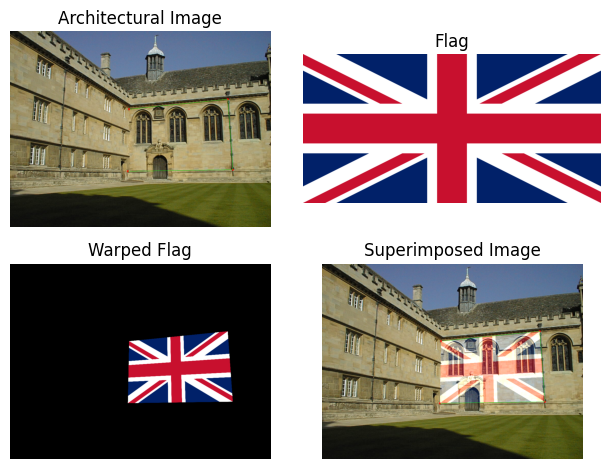

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize a list to store the selected points
selected_points = []

# Calculate the centroid of the points
def calculate_centroid(points):
    return np.mean(points, axis=0)

# Callback function for mouse click events
def mouse_click(event, x, y, flags, param):
    global selected_points, architectural_image  # Declare global variables

    if event == cv2.EVENT_LBUTTONDOWN:
        # Add point only if we have less than 4 points
        if len(selected_points) < 4:
            selected_points.append((x, y))
            cv2.circle(architectural_image, (x, y), 4, (0, 0, 255), -1)

            # Draw lines connecting the selected points
            if len(selected_points) > 1:
                cv2.polylines(architectural_image, [np.array(selected_points)], isClosed=False, color=(0, 255, 0), thickness=1)

            cv2.imshow('Image', architectural_image)
        else:
            print("Four points already selected. Right-click to remove the last point if needed.")

    if event == cv2.EVENT_RBUTTONDOWN:  # Right-click to remove the last selected point
        if selected_points:
            selected_points.pop()
            architectural_image = cv2.imread('005.jpg')  # Reload image to reset
            for pt in selected_points:
                cv2.circle(architectural_image, pt, 4, (0, 0, 255), -1)
            if len(selected_points) > 1:
                cv2.polylines(architectural_image, [np.array(selected_points)], isClosed=False, color=(0, 255, 0), thickness=1)
            cv2.imshow('Image', architectural_image)
            print("Last point removed. Current points:", selected_points)

# Load the images
architectural_image = cv2.imread('005.jpg')
flag = cv2.imread('Flag.png')

# Normalize images to range [0, 1]
architectural_image = architectural_image.astype(np.float32) / 255.0  # Normalize properly
flag = flag.astype(np.float32) / 255.0  # Normalize properly

print("Image shape:", architectural_image.shape)
print("Flag shape:", flag.shape)

# Show the image and set the mouse callback
cv2.imshow('Image', architectural_image)
cv2.setMouseCallback('Image', mouse_click)

# Instructions for the user
print("Please select four points in clockwise order by left-clicking.")
print("You can right-click to remove the last selected point.")

# Wait for the user to select four points
while len(selected_points) < 4:
    cv2.waitKey(1)

cv2.destroyAllWindows()

# Ensure points are in clockwise order
def sort_points_clockwise(points):
    centroid = calculate_centroid(points)
    sorted_points = sorted(points, key=lambda point: np.arctan2(point[1] - centroid[1], point[0] - centroid[0]))
    
    # Rearrange sorted points to make sure they are in clockwise order
    return [sorted_points[0], sorted_points[1], sorted_points[3], sorted_points[2]]

# Order the points
ordered_points = sort_points_clockwise(selected_points)

print("Ordered Points (Clockwise):", ordered_points)

# Prepare for perspective transformation
dst_points = np.array(ordered_points).astype(np.float32)
h2, w2 = flag.shape[:2]
src_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

# Calculate the homography matrix
H = cv2.getPerspectiveTransform(src_points, dst_points)  # Homography matrix
print('Homography matrix:\n', H)

# Warp the flag using the calculated homography
flag_warped = cv2.warpPerspective(flag, H, (architectural_image.shape[1], architectural_image.shape[0]))
superimposed_image = cv2.addWeighted(architectural_image, 1, flag_warped, 0.5, 0)

# Display results using matplotlib
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(architectural_image, cv2.COLOR_BGR2RGB))
plt.title('Architectural Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(flag, cv2.COLOR_BGR2RGB))
plt.title('Flag')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(flag_warped, cv2.COLOR_BGR2RGB))
plt.title('Warped Flag')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))
plt.title('Superimposed Image')
plt.axis('off')

plt.tight_layout()
plt.show()


Image shape: (1200, 1200, 3)
Flag shape: (225, 225, 3)
Please select four points in clockwise order by left-clicking.
You can right-click to remove the last selected point.
Ordered Points (Clockwise): [(155, 40), (682, 154), (167, 608), (702, 603)]
Homography matrix:
 [[ 3.14472912e+00  3.48885791e-02  1.55000000e+02]
 [ 6.87877901e-01  2.45729229e+00  4.00000000e+01]
 [ 1.17669633e-03 -1.10447630e-04  1.00000000e+00]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


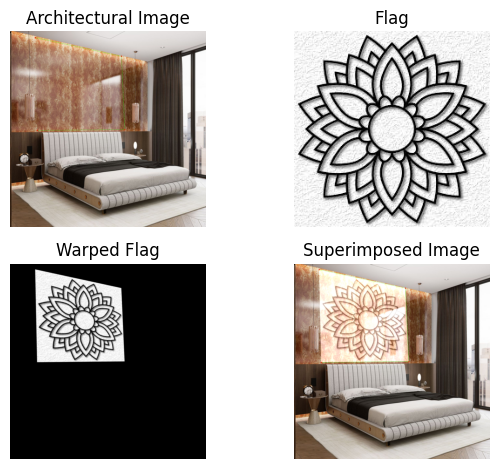

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize a list to store the selected points
selected_points = []

# Calculate the centroid of the points
def calculate_centroid(points):
    return np.mean(points, axis=0)

# Callback function for mouse click events
def mouse_click(event, x, y, flags, param):
    global selected_points, architectural_image  # Declare global variables

    if event == cv2.EVENT_LBUTTONDOWN:
        # Add point only if we have less than 4 points
        if len(selected_points) < 4:
            selected_points.append((x, y))
            cv2.circle(architectural_image, (x, y), 4, (0, 0, 255), -1)

            # Draw lines connecting the selected points
            if len(selected_points) > 1:
                cv2.polylines(architectural_image, [np.array(selected_points)], isClosed=False, color=(0, 255, 0), thickness=1)

            cv2.imshow('Image', architectural_image)
        else:
            print("Four points already selected. Right-click to remove the last point if needed.")

    if event == cv2.EVENT_RBUTTONDOWN:  # Right-click to remove the last selected point
        if selected_points:
            selected_points.pop()
            architectural_image = cv2.imread('bedroom.jpeg')  # Reload image to reset
            for pt in selected_points:
                cv2.circle(architectural_image, pt, 4, (0, 0, 255), -1)
            if len(selected_points) > 1:
                cv2.polylines(architectural_image, [np.array(selected_points)], isClosed=False, color=(0, 255, 0), thickness=1)
            cv2.imshow('Image', architectural_image)
            print("Last point removed. Current points:", selected_points)

# Load the images
architectural_image = cv2.imread('bedroom.jpeg')
flag = cv2.imread('adithya.jpg')

# Normalize images to range [0, 1]
architectural_image = architectural_image.astype(np.float32) / 255.0  # Normalize properly
flag = flag.astype(np.float32) / 255.0  # Normalize properly

print("Image shape:", architectural_image.shape)
print("Flag shape:", flag.shape)

# Show the image and set the mouse callback
cv2.imshow('Image', architectural_image)
cv2.setMouseCallback('Image', mouse_click)

# Instructions for the user
print("Please select four points in clockwise order by left-clicking.")
print("You can right-click to remove the last selected point.")

# Wait for the user to select four points
while len(selected_points) < 4:
    cv2.waitKey(1)

cv2.destroyAllWindows()

# Ensure points are in clockwise order
def sort_points_clockwise(points):
    centroid = calculate_centroid(points)
    sorted_points = sorted(points, key=lambda point: np.arctan2(point[1] - centroid[1], point[0] - centroid[0]))
    
    # Rearrange sorted points to make sure they are in clockwise order
    return [sorted_points[0], sorted_points[1], sorted_points[3], sorted_points[2]]

# Order the points
ordered_points = sort_points_clockwise(selected_points)

print("Ordered Points (Clockwise):", ordered_points)

# Prepare for perspective transformation
dst_points = np.array(ordered_points).astype(np.float32)
h2, w2 = flag.shape[:2]
src_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

# Calculate the homography matrix
H = cv2.getPerspectiveTransform(src_points, dst_points)  # Homography matrix
print('Homography matrix:\n', H)

# Warp the flag using the calculated homography
flag_warped = cv2.warpPerspective(flag, H, (architectural_image.shape[1], architectural_image.shape[0]))
superimposed_image = cv2.addWeighted(architectural_image, 1, flag_warped, 0.5, 0)

# Display results using matplotlib
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(architectural_image, cv2.COLOR_BGR2RGB))
plt.title('Architectural Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(flag, cv2.COLOR_BGR2RGB))
plt.title('Flag')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(flag_warped, cv2.COLOR_BGR2RGB))
plt.title('Warped Flag')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))
plt.title('Superimposed Image')
plt.axis('off')

plt.tight_layout()
plt.show()
